In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timebudget import timebudget
from cplAE_MET.utils.load_config import load_config
from cplAE_MET.utils.dataset import load_MET_dataset 
from cplAE_MET.utils.plots import plot_m
from cplAE_MET.utils.dataclass import met_dataclass

In [2]:
import torch
from cplAE_MET.models.subnetworks_E import AE_E
from cplAE_MET.models.subnetworks_M import AE_M
from cplAE_MET.models.subnetworks_ME import AE_ME_int

In [3]:
dir_pth = load_config('config.toml')
D = load_MET_dataset(dir_pth['MET_data'])
dat = met_dataclass(D)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# E data -----------
xe = torch.as_tensor(dat.XE).float().to(device)

# get indices of valid data points before nan -> 0.0
valid_xe = ~torch.isnan(xe)
xe = torch.nan_to_num(xe)
gnoise_std = torch.var(xe, dim=0, keepdim=True).sqrt()

# M data -----------
xm = np.expand_dims(dat.XM_centered,axis=1)
xm = torch.as_tensor(xm).float().to(device)
xsd = torch.as_tensor(dat.Xsd).float().to(device)

# get indices of valid data points before nan -> 0.0
valid_xm = ~torch.isnan(xm)
valid_xsd = ~torch.isnan(xsd)

# xm and xsd nan -> 0.0
xm = torch.nan_to_num(xm)
xsd = torch.nan_to_num(xsd)

In [5]:
from itertools import chain

# Model init -----------
model_config = dict(latent_dim=2,
                    E=dict(gnoise_std_frac=0.05,
                            dropout_p=0.2))

ae_e = AE_E(config=model_config, gnoise_std=gnoise_std)
ae_m = AE_M(config=model_config)
ae_me = AE_ME_int(config=model_config)


ae_m.to(device)
ae_e.to(device)
ae_me.to(device)

optimizer = torch.optim.Adam(chain(ae_e.parameters(),ae_m.parameters(), ae_me.parameters()), lr=0.001)

step: 99 loss: 1.5384202003479004


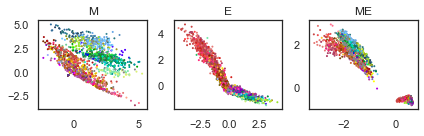

step: 199 loss: 1.259899616241455


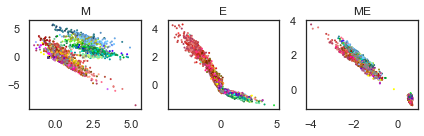

step: 299 loss: 1.2095125913619995


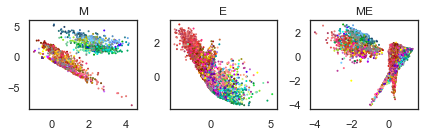

step: 399 loss: 1.1928980350494385


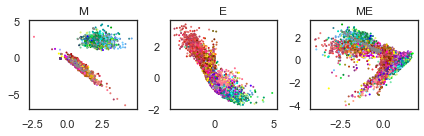

step: 499 loss: 1.1922039985656738


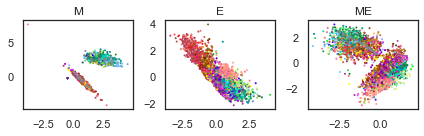

In [6]:
# Train loop -----------
for step in range(500):
    optimizer.zero_grad()

    # e arm
    ze_int_enc = ae_e.enc_xe_to_ze_int(xe)
    ze = ae_e.enc_ze_int_to_ze(ze_int_enc.detach())
    ze_int_dec = ae_e.dec_ze_to_ze_int(ze)
    with torch.no_grad():
        xre = ae_e.dec_ze_int_to_xe(ze_int_dec)

    # m arm
    zm_int_enc = ae_m.enc_xm_to_zm_int(xm, xsd)
    zm = ae_m.enc_zm_int_to_zm(zm_int_enc.detach())
    zm_int_dec = ae_m.dec_zm_to_zm_int(zm)
    with torch.no_grad():
        xrm, xrsd = ae_m.dec_zm_int_to_xm(zm_int_dec,
                                        ae_m.enc_xm_to_zm_int.pool_0_ind,
                                        ae_m.enc_xm_to_zm_int.pool_1_ind)

    # me arm
    zme = ae_me.enc_zme_int_to_zme(zm_int_enc, ze_int_enc)
    zm_int_dec, ze_int_dec = ae_me.dec_zme_to_zme_int(zme)

    # connect back to m and e
    xre_me = ae_e.dec_ze_int_to_xe(ze_int_dec)
    xrm_me, xrsd_me = ae_m.dec_zm_int_to_xm(zm_int_dec,
                                        ae_m.enc_xm_to_zm_int.pool_0_ind,
                                        ae_m.enc_xm_to_zm_int.pool_1_ind)

    loss_rec_e = torch.mean(torch.masked_select(torch.square(xe-xre), valid_xe))
    loss_rec_m = torch.mean(torch.masked_select(torch.square(xm-xrm), valid_xm))
    loss_rec_sd = torch.mean(torch.masked_select(torch.square(xsd-xrsd), valid_xsd))

    loss_rec_e_me = torch.mean(torch.masked_select(torch.square(xe-xre_me), valid_xe))
    loss_rec_m_me = torch.mean(torch.masked_select(torch.square(xm-xrm_me), valid_xm))
    loss_rec_sd_me = torch.mean(torch.masked_select(torch.square(xsd-xrsd_me), valid_xsd))

    loss = loss_rec_e + loss_rec_m + 0*loss_rec_sd \
        + loss_rec_e_me + loss_rec_m_me + 0*loss_rec_sd_me

    loss.backward()
    optimizer.step()
    if (step+1) % 100 == 0:
        print(f'step: {step} loss: {loss.to("cpu").detach().numpy()}')
        ze = ze.detach().to('cpu').numpy()
        zm = zm.detach().to('cpu').numpy()
        zme = zme.detach().to('cpu').numpy()
        f,ax = plt.subplots(1,3, figsize=(6,2))
        ax[0].scatter(zm[:,0],zm[:,1],c=dat.cluster_color,s=1)
        ax[0].set(title='M')
        ax[1].scatter(ze[:,0],ze[:,1],c=dat.cluster_color,s=1)
        ax[1].set(title='E')
        ax[2].scatter(zme[:,0],zme[:,1],c=dat.cluster_color,s=1)
        ax[2].set(title='ME')
        plt.tight_layout()
        plt.show()

In [ ]:
from matplotlib.pyplot import legend
import plotly.express as px
df = pd.DataFrame(dict(ze0=ze[:, 0], ze1=ze[:, 1],
                       zm0=zm[:, 0], zm1=zm[:, 1],
                       color=dat.cluster_color,
                       id=dat.specimen_id,
                       cluster=dat.cluster_label))

fig = px.scatter(df,
                 x="zm0", y="zm1", color="cluster",
                 hover_data=["id", "cluster"],
                 color_discrete_map=dict(zip(df.cluster, df.color)),
                 range_x=(-5,5),
                 range_y=(-5,5),
                 width=800,height=600)
fig.show()

fig = px.scatter(df,
                 x="ze0", y="ze1", color="cluster",
                 hover_data=["id", "cluster"],
                 color_discrete_map=dict(zip(df.cluster, df.color)),
                 range_x=(-5,5),
                 range_y=(-5,5),
                 width=800,height=600)
fig.show()